# Forecast Random Forest

1st August 2022

Iterates on CNN2 to include all the geostationary data.

In [1]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
import copy
import os
import time
#from google.cloud import storage
from datetime import timedelta, timezone, datetime
import zarr
#from google.cloud import storage
import pickle5
import pickle
import pandas as pd
from datetime import datetime, timedelta
import fsspec
#from gcsfs import GCSFileSystem
from tqdm import tqdm, notebook
#from google.cloud import bigquery
import seaborn as sns
import jax
import jax.numpy as jnp
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import scipy.special as scp
from sklearn.ensemble import RandomForestClassifier

from itertools import permutations, combinations
from scipy.stats import norm
import math


%load_ext autoreload
%autoreload 2


In [2]:
!pip install google-cloud

In [3]:
# Custom libraries
import sys
sys.path.insert(1,'/home/emiliano/Documents/FDL/clean_code/src/')
import dataprep as dp
from hsic import *
#from rf import *
from icp import *
#import icp_nets as icpn

hsic2.py


## New Load Data

### 1.5 | Split data

In [4]:
ML_ready_root = "../data/"
file = "Himawari_lazyload_dataset_keys_prediction_v1.pkl"

keys = pickle5.load( open( ML_ready_root+file, "rb" ) )
keys_image, keys_era5 = keys

In [5]:
keys = keys_era5

In [6]:
k0 = keys[1]["flag_then"][0]
k0

[True, True, False, False, True, True]

In [7]:
k0[1:len(k0)]

[True, False, False, True, True]

In [8]:
k0[0:(len(k0)-1)]

[True, True, False, False, True]

In [9]:
[k0[0]]+(np.array(k0[1:len(k0)])*np.logical_not(k0[0:(len(k0)-1)])).tolist()

[True, False, False, False, True, False]

In [10]:
def correctFlags(ks):
    return [ks[0]]+(np.array(ks[1:len(ks)])*np.logical_not(ks[0:(len(ks)-1)])).tolist()

In [11]:
i = 0
correctedFlags = [correctFlags(keys[1]["flag_then"][i]) for i in range(len(keys[1]["flag_then"]))]

In [12]:
np.sum(dp.flatten(keys[1]["flag_then"]))

1167

In [13]:
np.sum(dp.flatten(correctedFlags))

447

In [14]:
len(dp.flatten(correctedFlags))

6919

In [15]:
i = 0
indxKeep, = np.where([dp.flatten(correctedFlags)[i]==dp.flatten(keys[1]["flag_then"])[i] for i in range(len(dp.flatten(correctedFlags)))])

In [16]:
indxKeep.shape

(6199,)

In [17]:
envVars = np.load(ML_ready_root+'env_era5_pred_v1.npy')
envVars.shape

(6919, 5)

In [18]:
envVars[0:5,]

array([[ 151.98555486,  -31.58987524, 2019.91232877, 2019.        ,
           0.        ],
       [ 151.98555486,  -31.58987524, 2019.91232877, 2019.        ,
           0.        ],
       [ 151.98555486,  -31.58987524, 2019.91232877, 2019.        ,
           0.        ],
       [ 151.98555486,  -31.58987524, 2019.91232877, 2019.        ,
           0.        ],
       [ 151.98555486,  -31.58987524, 2019.91506849, 2019.        ,
           0.        ]])


Meteorological Era 5 variables

| Variable index | Short name | Long name |
| -------------- | ---------- | --------- |
| 0  | u10  | 10m u component of wind | 
| 1  | v10  | 10m v component of wind |
| 2  | fg10 | 10m wind gust since previous post processing |
| 3  | blh  | boundary layer height |
| 4  | cape | convective available potential energy |
| 5  | cin  | convective inhibition |
| 6  | z    | geopotential |
| 7  | slhf | surface latent heat flux |
| 8  | sshf | surface sensible heat flux |
| 9 | w    | surface vertical velocity |
| 10 | u    | u component of wind at 250hPa |
| 11 | v    | v component of wind at 250hPa |
| 12 | cvh  | fraction of high vegetation |
| 13 | cvl  | fraction of low vegetation |
| 14 | tvh  | type of high vegetation |
| 15 | tvl  | type of low vegetation |
| 16 | r650 | relative humidity at 650hPa |
| 17 | r750 | relative humidity at 750hPa |
| 18 | r850 | relative humidity at 850hPa |

In [19]:
#cube = np.load(ML_ready_root+'x_image_det_v1.npy')
#labels = np.load(ML_ready_root+'y_image_det_v1.npy')
#cube = np.load(ML_ready_root+'x_image_pred_v1.npy')
#labels = np.load(ML_ready_root+'y_image_pred_v1.npy')

#cube = np.load(ML_ready_root+'xFeat_era5_3vs_pred_v1.npy')
#labels = np.load(ML_ready_root+'y_era5_3vs_pred_v1.npy')
#cube = np.load(ML_ready_root+'xFeat_era5_19vs_pred_v1.npy')
cube = np.load(ML_ready_root+'xFeat_era5_25vs_pred_v2.npy')
labels = np.load(ML_ready_root+'y_era5_19vs_pred_v1.npy')

#cube = np.load(ML_ready_root+'xFeat_era5_3vs_pred_oracle_v1.npy')
#labels = np.load(ML_ready_root+'y_era5_3vs_pred_oracle_v1.npy')
#cube = np.load(ML_ready_root+'xFeat_era5_19vs_pred_oracle_v1.npy')
#labels = np.load(ML_ready_root+'y_era5_19vs_pred_oracle_v1.npy')

#cube = np.load(ML_ready_root+'xFeat_era5_3vs_det_v1.npy')
#labels = np.load(ML_ready_root+'y_era5_3vs_det_v1.npy')
#cube = np.load(ML_ready_root+'xFeat_era5_19vs_det_v1.npy')
#labels = np.load(ML_ready_root+'y_era5_19vs_det_v1.npy')

In [20]:
def allZeros(x):
    return np.all(x==0)
indxZeros = np.where(np.apply_along_axis(allZeros,0,cube))
indxZeros

(array([], dtype=int64),)

In [21]:
#cube = cube[:,0:66]
#cube = cube[:,66:99]
#cube = cube[:,66:275]

In [22]:
cube.shape

(6919, 318)

In [23]:
labels.shape

(6919,)

In [24]:
np.sum(labels)

1167

In [25]:
labels

array([1, 1, 0, ..., 0, 0, 0])

In [26]:
np.sum(np.isnan(cube))

0

In [27]:
11*9

99

In [28]:
11*25

275

In [29]:
11*6

66

In [30]:
def norml(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))


In [31]:
def norml2(x):
    den = (np.nanmax(x)-np.nanmin(x))
    if den>0:
        #print("ya")
        res = (x-np.nanmin(x))/den
    else: 
        print("bla")
        res = x
    return res


In [32]:
def norml3(x,i):
    #print(i)
    minX = np.quantile(x[x>0], 0.01)
    maxX = np.quantile(x[x>0], 0.99)
    res = x
    res[x<=minX]=minX
    res[x>=maxX]=maxX
    res = (res-minX)/(maxX-minX)
    
    return  res

In [33]:
np.max(cube)

866571.1794800136

In [34]:
#np.quantile(cube[:,145], 0.01)

In [35]:
#sns.distplot(cube[:,145])

In [36]:
cube.shape

(6919, 318)

In [37]:
i = 0
cube = np.array([norml2(cube[:,i]) for i in range(cube.shape[1])])
cube = np.transpose(cube,[1,0])
cube.shape


(6919, 318)

In [38]:
cube[np.isnan(cube)] = 0
np.sum(np.isnan(cube))

0

In [39]:
np.prod(cube.shape)

2200242

In [40]:
np.sum(np.isinf(cube))

0

In [41]:
25*11

275

In [42]:
#cube = np.transpose(np.array([norml(cube[:,i,:,:]) for i in range(cube.shape[1])]),[1,0,2,3])

In [43]:
event_ids = np.array(keys[1]["event_id"])[np.array(keys[0]["level1_key"])]

In [44]:
len(dp.flatten(keys[1]["full_flag_now"]))

6919

In [45]:
len(dp.flatten(keys[1]["flag_then"]))

6919

In [46]:
repos = "../data/"
file = "wildfires.pkl"
wildfires = pickle5.load( open( repos+file, "rb" ) )
wildfires.loc[pd.isnull(wildfires.wildfire_id),"wildfire_id"] = wildfires.loc[pd.isnull(wildfires.wildfire_id),"pyroCb_id"]

In [47]:
wildfires.head()

,pyroCb_id,pyroCb_date_utc,pyroCb_time_utc,pyroCb_longitude,pyroCb_latitude,country,region,satellite,wildfire_id,wildfire_ini_date_utc,wildfire_end_date_utc,length_days,wildfire_centroid_longitude,wildfire_centroid_latitude,extract_longitude,extract_latitude,extract_ini_date_utc,extract_end_date_utc,time_zone,length_fire
0,260,2022-06-11,2300.0,-155.6,63.3,US,Alaska,GOES,260,NaT,NaT,None,NaN,NaN,-155.600000,63.30000,2022-06-08 08:00:00+00:00,2022-06-14 08:00:00+00:00,America/Anchorage,6
1,258,2022-06-12,300.0,-153.4,63.8,US,Alaska,GOES,258,NaT,NaT,None,NaN,NaN,-153.400000,63.80000,2022-06-09 08:00:00+00:00,2022-06-15 08:00:00+00:00,America/Anchorage,6
2,265,2022-07-02,550.0,-149.7,65.5,US,Alaska,GOES,265,NaT,NaT,None,NaN,NaN,-149.700000,65.50000,2022-06-29 08:00:00+00:00,2022-07-05 08:00:00+00:00,America/Anchorage,6
3,259,2020-06-08,NaN,-149.6,65.9,US,Alaska,GOES,23353806,2020-06-05,2020-06-12,7,-149.536458,65.85841,-149.536458,65.85841,2020-06-05 08:00:00+00:00,2020-06-12 08:00:00+00:00,America/Anchorage,7
4,266,2022-07-02,719.0,-149.5,65.6,US,Alaska,GOES,266,NaT,NaT,None,NaN,NaN,-149.500000,65.60000,2022-06-29 08:00:00+00:00,2022-07-05 08:00:00+00:00,America/Anchorage,6


In [48]:
pyrocb_id = [int(ei.split("_")[0]) for ei in event_ids.tolist()]

In [49]:
event_df = pd.DataFrame({"pyrocb_id":pyrocb_id, "event_id":event_ids, "full_flag_now":dp.flatten(keys[1]["full_flag_now"]), "flag_then":dp.flatten(keys[1]["flag_then"])})
event_df.head()

,pyrocb_id,event_id,full_flag_now,flag_then
0,114,114_28,3,True
1,114,114_28,3,True
2,114,114_28,4,False
3,114,114_28,3,False
4,114,114_28,3,True


In [50]:
event_df = event_df.merge(wildfires[["pyroCb_id","wildfire_id"]], how="left", left_on="pyrocb_id", right_on="pyroCb_id")
event_df.shape

(6919, 6)

In [51]:
event_df = pd.concat([event_df, pd.DataFrame(envVars,columns=["lon","lat","date","year","sat"])], axis=1)
event_df.shape

(6919, 11)

In [52]:
indx, = np.where(event_df.full_flag_now<4)
indx.shape

(6608,)

In [53]:
# exlcude pyrocbs now
#cube = cube[indx,]
#labels = labels[indx,]
#envVars = envVars[indx,]
#event_df = event_df.iloc[indx]
cube.shape

(6919, 318)

In [54]:
seg_base = event_df.drop_duplicates('wildfire_id')
seg_base.shape

(83, 11)

In [55]:
# GOES = 1, HIMAWARI = 0
seg_base[["pyrocb_id","sat"]].groupby(["sat"]).count()

,pyrocb_id
sat,
0.0,31
1.0,52


In [56]:
# GOES = 1, HIMAWARI = 0
seg_base[["pyrocb_id","sat","year"]].groupby(["sat","year"]).count()

pyrocb_id
sat year             
0.0 2019.0         24
    2020.0          4
    2021.0          3
1.0 2018.0          5
    2021.0         47

In [57]:
seg_base[["sat","lon","lat","date"]].head()

,sat,lon,lat,date
0,0.0,151.985555,-31.589875,2019.912329
6,0.0,151.956344,-32.318750,2019.890411
11,0.0,123.520000,-32.050000,2021.063014
17,0.0,150.218571,-35.233573,2020.013699
23,1.0,-119.806857,37.629127,2018.539726


In [58]:
def stdze(x):
    return (x-np.mean(x))/np.std(x)

In [59]:
def addCluster(seg_base, num_clusters,seed):
    np.random.seed(seed=seed)
    rnds = np.floor(np.arange(0,seg_base.shape[0])/17).astype(int)
    #seg_base2 = seg_base[["sat","lon","lat","date"]].to_numpy()
    seg_base2 = seg_base[["sat","lon","lat"]].to_numpy()
    seg_base2 = np.array([stdze(seg_base2[:,i]) for i in range(seg_base2.shape[1])]).T
    N = seg_base2.shape[0]
    cluster_size = N//num_clusters
    print("cluster size: ", cluster_size)
    labs = -1*np.ones(N)
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(seg_base2)
    grps = kmeans.labels_
    ids, cnt = np.unique(grps, return_counts=True)
    print(pd.DataFrame({"cluster":ids,"count":cnt}))
    o = np.argsort(cnt)
    DistMat = kmeans.fit_transform(seg_base2)
    
    # initialize
    indx_obs = np.arange(seg_base2.shape[0]).tolist()
    indx_cluster = ids[o][::-1].tolist()
    
    # loop through clusters from smallest to largest
    for i in range(len(indx_obs)):
        #print("i: ", i)
        o2 = np.argsort(DistMat[indx_obs,indx_cluster[0]])
        indx_lab = np.array(indx_obs)[o2[0]]
        labs[indx_lab] = indx_cluster[0]
        indx_cluster.pop(0)
        if len(indx_cluster)==0:
            indx_cluster = ids[o][::-1].tolist()
        indx_obs = list(set(indx_obs).difference([indx_lab]))
    
    
    #seg_base["cluster"]=np.array(labs).astype(int)
    seg_base["cluster_regional"]=np.array(grps).astype(int)
    seg_base["cluster_random"]=np.array(rnds).astype(int)
    return seg_base, seg_base2

In [60]:
rand = np.floor(np.arange(0,seg_base.shape[0])/17).astype(int)
cnt, uni = np.unique(rand, return_counts=True)
{"cnt":cnt, "uni":uni}

{'cnt': array([0, 1, 2, 3, 4]), 'uni': array([17, 17, 17, 17, 15])}

In [61]:
83/5

16.6

In [62]:
num_clusters=5
seed = 123456
seg_base, X = addCluster(seg_base, num_clusters=num_clusters, seed=seed)

cluster size:  16
   cluster  count
0        0     12
1        1     20
2        2     19
3        3     20
4        4     12


/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [63]:
results_root = "..//results/"
version = "v0"
file = "seg_base"
fileRes = results_root+file+"_"+version+".pkl" 
fileRes

'..//results/seg_base_v0.pkl'

In [64]:
with open(fileRes, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(seg_base, output, pickle.HIGHEST_PROTOCOL)


In [65]:
cluster_var = "cluster_random"
#cluster_var = "cluster_regional"
seg_base[["pyrocb_id",cluster_var]].groupby(cluster_var).count()

,pyrocb_id
cluster_random,
0,17
1,17
2,17
3,17
4,15


In [66]:
metrics.silhouette_score(X, seg_base[cluster_var], metric='euclidean')

-0.2766629442204502

In [67]:
N = seg_base.shape[0]
cluster_size = N//num_clusters

rand_labs = np.arange(seg_base.shape[0])
rand_labs = (rand_labs//cluster_size)%num_clusters
indx = np.random.choice(seg_base.shape[0], size=seg_base.shape[0], replace=False)
rand_labs = rand_labs[indx]

In [68]:
metrics.silhouette_score(X, rand_labs, metric='euclidean')

-0.20740481753718246

In [69]:
seg_base.head()

,pyrocb_id,event_id,full_flag_now,flag_then,pyroCb_id,wildfire_id,lon,lat,date,year,sat,cluster_regional,cluster_random
0,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,2,0
6,171,171_8,2,False,171,22810493,151.956344,-32.318750,2019.890411,2019.0,0.0,2,0
11,126,126_5,1,False,126,126,123.520000,-32.050000,2021.063014,2021.0,0.0,0,0
17,91,91_46,3,False,91,22810914,150.218571,-35.233573,2020.013699,2020.0,0.0,2,0
23,163,163_5,2,True,163,21121935,-119.806857,37.629127,2018.539726,2018.0,1.0,4,0


In [70]:
results_root = "/home/jupyter/ML_ready/results/"
typee = cluster_var
fileRes = results_root+typee+"_clustering.png"
fileRes

'/home/jupyter/ML_ready/results/cluster_random_clustering.png'

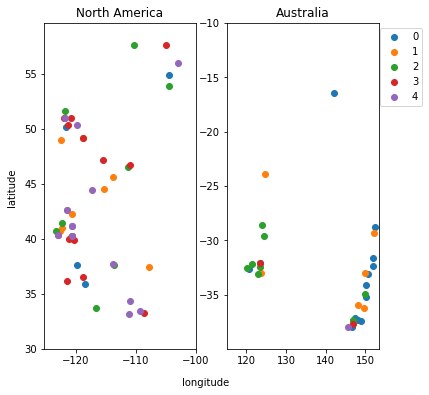

In [71]:
i = 0
fig, ax = plt.subplots(1, 2, figsize=(6, 6))  # setup the plot
for i in np.unique(seg_base[cluster_var]):
    scat1 = ax[0].scatter(seg_base.loc[seg_base[cluster_var]==i]["lon"], seg_base.loc[seg_base[cluster_var]==i]["lat"], label=i)#, s=date_norm
    scat1 = ax[1].scatter(seg_base.loc[seg_base[cluster_var]==i]["lon"], seg_base.loc[seg_base[cluster_var]==i]["lat"], label=i)
ax[0].set_xlim([np.min(seg_base["lon"])-2, -100])
ax[0].set_ylim([30,np.max(seg_base["lat"])+2])

ax[1].set_xlim([115,np.max(seg_base["lon"])+1])
ax[1].set_ylim([np.min(seg_base["lat"])-2, -10])


fig.text(0.5, 0.04, 'longitude', ha='center')
fig.text(0.04, 0.5, 'latitude', va='center', rotation='vertical')



ax[0].set_title('North America')
ax[1].set_title('Australia')
ax[1].legend(bbox_to_anchor=(1.32, 1.0))
#plt.savefig(fileRes, format='png', dpi=300)


In [72]:
event_df = event_df.merge(seg_base[["wildfire_id","cluster_regional","cluster_random"]], how="left",on="wildfire_id")

In [73]:
event_df.head()

,pyrocb_id,event_id,full_flag_now,flag_then,pyroCb_id,wildfire_id,lon,lat,date,year,sat,cluster_regional,cluster_random
0,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,2,0
1,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,2,0
2,114,114_28,4,False,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,2,0
3,114,114_28,3,False,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,2,0
4,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.915068,2019.0,0.0,2,0


In [74]:
event_df[["pyrocb_id",cluster_var]].groupby(cluster_var).count()

,pyrocb_id
cluster_random,
0,2751
1,1963
2,1380
3,495
4,330


In [75]:
event_df.shape

(6919, 13)

In [76]:
#file = "/home/jupyter/elevation/alwdgg.tif"
#da = xr.open_rasterio(file)
#alt = [da.interp(x=event_df.iloc[i].lon, y = event_df.iloc[i].lat, method="linear").values[0] for i in range(event_df.shape[0])]

In [77]:
#event_df["altitude"] = alt
#def meanAlt(x):
#    return np.mean(x.altitude)
#event_df[["pyrocb_id","cluster","altitude"]].groupby("cluster").apply(meanAlt)

In [78]:
print(envVars.shape)
print(cube.shape)
print(labels.shape)
print(len(keys[0]["level1_key"]))

(6919, 5)
(6919, 318)
(6919,)
6919


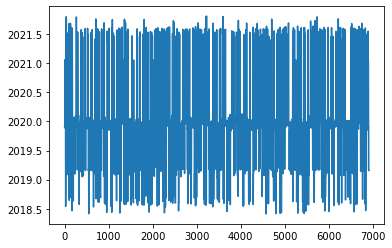

In [79]:
plt.plot(envVars[:,2])

In [80]:
mu_env = [np.mean(envVars[:,i]) for i in range(envVars.shape[1])]
sigma_env = [np.std(envVars[:,i]) for i in range(envVars.shape[1])]

In [81]:
mu_env

[82.03730074296445,
 -15.836401755772682,
 2019.9820624961642,
 2019.45281109987,
 0.23023558317675966]

In [82]:
sigma_env

[110.63039472732746,
 32.406044911163136,
 0.8347076386002498,
 0.8607601604282905,
 0.42098356193088715]

In [83]:
satellite_list = dp.flatten(keys[1]["satellite"])

In [84]:
satellite_list = np.array(satellite_list)

In [85]:
event_ids = np.array(keys[1]["event_id"])[np.array(keys[0]["level1_key"])]

In [86]:
aux = [(e,v) for (e,v) in zip(event_ids.astype(float), envVars[:,2])]

In [87]:
aux = np.array( aux, dtype=[('x', 'float'), ('y', 'float')])
aux.shape


(6919,)

In [88]:
o = np.argsort(aux, order=('x','y'))


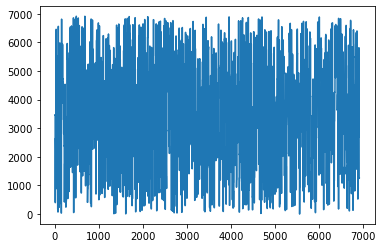

In [89]:
plt.plot(o)

In [90]:
event_ids[o]

array(['63_1', '63_1', '63_1', ..., '172_18', '172_18', '172_18'],
      dtype='<U6')

In [91]:
envVars[o,2]

array([2019.04657534, 2019.04657534, 2019.04657534, ..., 2020.02739726,
       2020.02739726, 2020.02739726])

In [92]:
#o = np.argsort(envVars[:,2])
#envVars = envVars[o,:]
#cube = cube[o,:]
#labels = labels[o]
#satellite_list = satellite_list[o]
#event_df= event_df.iloc[o]

In [93]:

#envVars = envVars[indxKeep,:]
#cube = cube[indxKeep,:]
#labels = labels[indxKeep]
#satellite_list = satellite_list[indxKeep]
#event_df= event_df.iloc[indxKeep]

In [94]:
cube.shape

(6919, 318)

In [95]:
cube.shape

(6919, 318)

In [96]:
event_df.shape

(6919, 13)

In [97]:
np.sum(event_df.flag_then)

1167

In [98]:
np.sum(labels)

1167

In [99]:
event_df[["flag_then",cluster_var,"pyrocb_id"]].groupby([cluster_var,"flag_then"]).count()

pyrocb_id
cluster_random flag_then           
0              False           2334
               True             417
1              False           1657
               True             306
2              False           1204
               True             176
3              False            325
               True             170
4              False            232
               True              98

In [100]:
event_df[["flag_then","full_flag_now","pyrocb_id"]].groupby(["full_flag_now","flag_then"]).count()

pyrocb_id
full_flag_now flag_then           
0             False            207
              True               4
1             False           3025
              True             192
2             False           1122
              True             283
3             False           1203
              True             572
4             False            195
              True             116

In [101]:
# cluster, wildfire_id, red_flag_now, flag_then

In [102]:
event_df[["pyrocb_id","full_flag_now"]].groupby("full_flag_now").count()

,pyrocb_id
full_flag_now,
0,211
1,3217
2,1405
3,1775
4,311


In [103]:
mydict = {0:"none", 1:"none", 2:"conv", 3:"deep conv",4:"pyrocb"}

In [104]:
event_df["red_flag_now"] =event_df["full_flag_now"].replace(mydict)
event_df[["pyrocb_id","red_flag_now"]].groupby("red_flag_now").count()

,pyrocb_id
red_flag_now,
conv,1405
deep conv,1775
none,3428
pyrocb,311


In [105]:
event_df.head()

,pyrocb_id,event_id,full_flag_now,flag_then,pyroCb_id,wildfire_id,lon,lat,date,year,sat,cluster_regional,cluster_random,red_flag_now
0,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,2,0,deep conv
1,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,2,0,deep conv
2,114,114_28,4,False,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,2,0,pyrocb
3,114,114_28,3,False,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,2,0,deep conv
4,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.915068,2019.0,0.0,2,0,deep conv


In [106]:
#cluster = 0
#event_df_clus = event_df.loc[event_df.cluster==cluster]
tab = event_df[["cluster_regional","cluster_random","pyrocb_id","wildfire_id","red_flag_now","flag_then"]].groupby([cluster_var,"wildfire_id","red_flag_now","flag_then"]).count()

In [107]:
np.all(tab.to_numpy()>0)

True

In [108]:
tab = tab.reset_index().rename(columns={"pyrocb_id":"freq"})

In [109]:
np.max(tab.freq)

278

In [110]:
np.max(tab.freq)*tab.shape[0]

117038

In [111]:
tab["weight"]= 1/tab.freq

In [112]:
tab.head()

,cluster_random,wildfire_id,red_flag_now,flag_then,cluster_regional,freq,weight
0,0,126,conv,False,7,7,0.142857
1,0,126,deep conv,False,8,8,0.125000
2,0,126,deep conv,True,1,1,1.000000
3,0,126,none,False,16,16,0.062500
4,0,126,pyrocb,False,4,4,0.250000


In [113]:
event_df = event_df.merge(tab[["cluster_regional","cluster_random","wildfire_id","red_flag_now","flag_then","weight"]], how="left", on=["cluster_regional","cluster_random","wildfire_id","red_flag_now","flag_then"])

In [114]:
mu = [np.mean(cube[:,i]) for i in range(cube.shape[1])]
sigma = [np.std(cube[:,i]) for i in range(cube.shape[1])]

In [115]:
from sklearn.model_selection import train_test_split

In [116]:
#X_train, X_val, y_train, y_val = train_test_split(big_datacube, flag_list, test_size=0.20, random_state=42, stratify=None, shuffle=False)
#y_val.shape

In [117]:
cutoff = int(envVars.shape[0]*0.8)
cutoff

5535

In [118]:
cube.shape

(6919, 318)

In [119]:
np.sum(np.isnan(cube))

0

In [120]:
# By satellite and day
#indx1,  = np.where(satellite_list != "Himawari")
#num_rem = int(cube.shape[0]*0.2)-indx1.shape[0]
#print(num_rem )
#indx2, = np.where(satellite_list == "Himawari")
#indx2 = indx2[0:num_rem]
#indx_val = np.hstack([indx1, indx2])
#indx_val.shape

In [121]:
# by event_id and date
#indx_val = np.arange(cutoff, envVars.shape[0])
#indx_val

In [122]:
#by cluster
cluster = 1
indx_val, =  np.where(event_df[cluster_var]==cluster)

In [123]:
# by event_id: choose until you breach 20%

In [124]:
indx_train = np.array(list(set(np.arange(0, cube.shape[0])).difference(indx_val)))

In [125]:
cube.shape

(6919, 318)

In [126]:
X_train = cube[indx_train,:]
X_val = cube[indx_val,:]
y_train = labels[indx_train]
y_val = labels[indx_val]
Env_train = envVars[indx_train,3:5]
Env_val = envVars[indx_val,3:5]
y_val.shape

(1963,)

In [127]:
event_df.shape

(6919, 15)

In [128]:
event_df_train = event_df.iloc[indx_train]
event_df_val = event_df.iloc[indx_val]

In [129]:
envVars[0:10,]

array([[ 151.98555486,  -31.58987524, 2019.91232877, 2019.        ,
           0.        ],
       [ 151.98555486,  -31.58987524, 2019.91232877, 2019.        ,
           0.        ],
       [ 151.98555486,  -31.58987524, 2019.91232877, 2019.        ,
           0.        ],
       [ 151.98555486,  -31.58987524, 2019.91232877, 2019.        ,
           0.        ],
       [ 151.98555486,  -31.58987524, 2019.91506849, 2019.        ,
           0.        ],
       [ 151.98555486,  -31.58987524, 2019.91506849, 2019.        ,
           0.        ],
       [ 151.956344  ,  -32.31875   , 2019.89041096, 2019.        ,
           0.        ],
       [ 151.956344  ,  -32.31875   , 2019.89041096, 2019.        ,
           0.        ],
       [ 151.956344  ,  -32.31875   , 2019.89041096, 2019.        ,
           0.        ],
       [ 151.956344  ,  -32.31875   , 2019.89315068, 2019.        ,
           0.        ]])

In [130]:
#met_varss = ["u10", "v10", "fg10", "blh", "cape", "cin", "z", "slhf", "sshf", "w", "u", "v", "cvh", "cvl", "tvh", "tvl", "r650", "r750", "r850"]
met_varss = ["u10", "v10", "fg10", "blh", "cape", "cin", "z", "slhf", "sshf", "w", "u", "v", "cvh", "cvl", "tvh", "tvl", "r650", "r750", "r850","uv10", "uv250", "alt", "typeH", "typeL"]
len(met_varss)

24

In [131]:
img_varss = ["ch1","ch2","ch3","ch4","ch5","ch6"]
varss = img_varss+met_varss

In [132]:
posts =np.arange(0,cube.shape[1]+1-10, 11)
posts = np.array(posts.tolist()+[posts[posts.shape[0]-1]+4,posts[posts.shape[0]-1]+10])
posts

array([  0,  11,  22,  33,  44,  55,  66,  77,  88,  99, 110, 121, 132,
       143, 154, 165, 176, 187, 198, 209, 220, 231, 242, 253, 264, 275,
       286, 297, 308, 312, 318])

# ICP

In [133]:
print(varss)
print(len(varss))
indxIncl = [10,21]
indxIncl = [0,4,5,13,16,17,18]
#indxIncl = [29]
indxIncl = np.arange(len(varss)).tolist()
indxIncl 
np.array(varss)[indxIncl].shape

['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'u10', 'v10', 'fg10', 'blh', 'cape', 'cin', 'z', 'slhf', 'sshf', 'w', 'u', 'v', 'cvh', 'cvl', 'tvh', 'tvl', 'r650', 'r750', 'r850', 'uv10', 'uv250', 'alt', 'typeH', 'typeL']
30


(30,)

In [134]:
i = 0
envv = np.array([(event_df["cluster_regional"]==i)*1 for i in np.arange(5)]).T
envv.shape

(6919, 5)

In [135]:
envVars.shape

(6919, 5)

In [136]:
30*11

330

In [137]:
event_df.head()

,pyrocb_id,event_id,full_flag_now,flag_then,pyroCb_id,wildfire_id,lon,lat,date,year,sat,cluster_regional,cluster_random,red_flag_now,weight
0,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,2,0,deep conv,NaN
1,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,2,0,deep conv,NaN
2,114,114_28,4,False,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,2,0,pyrocb,NaN
3,114,114_28,3,False,114,22810288,151.985555,-31.589875,2019.912329,2019.0,0.0,2,0,deep conv,NaN
4,114,114_28,3,True,114,22810288,151.985555,-31.589875,2019.915068,2019.0,0.0,2,0,deep conv,NaN


## Conditional independence test Y indep E | X based on delong test for diff of AUC and Random Forests

### Obtain out-of-sample probability of ocurrence using random forest with an without environment E variables

In [138]:

start_time = time.time()
y_pred_noE = getTestProbsWrapper(cube, labels, event_df, cluster_var, indxIncl, posts, numTrees=100)
y_pred_E = getTestProbsWrapper(cube, labels, event_df, cluster_var, indxIncl, posts, numTrees=100, envVar=envVars[:,0:3])
elapsed_time = time.time() - start_time
print("elapsed time: ", elapsed_time) # 30 secs for 5 folds, 10 combs each



elapsed time:  48.947426319122314


In [139]:
4000*30/60/60 # hours

33.333333333333336

In [140]:
type(indxIncl)

list

In [141]:
roc_auc_score(labels, y_pred_noE)

0.9023607749266155

In [142]:
roc_auc_score(labels, y_pred_E)

0.9029231515017168

In [143]:
elapsed_time/60 #3.4 mins for 500 trees, 41 secs for 100 trees

0.8157904386520386

In [144]:
np.sum(np.arange(len(varss))+1)*elapsed_time/60/60 #5 hours for greedy algo

6.322375899553299

In [145]:
len(varss)

30

In [146]:
varss

['ch1',
 'ch2',
 'ch3',
 'ch4',
 'ch5',
 'ch6',
 'u10',
 'v10',
 'fg10',
 'blh',
 'cape',
 'cin',
 'z',
 'slhf',
 'sshf',
 'w',
 'u',
 'v',
 'cvh',
 'cvl',
 'tvh',
 'tvl',
 'r650',
 'r750',
 'r850',
 'uv10',
 'uv250',
 'alt',
 'typeH',
 'typeL']

In [147]:

def comb(n,p):
    return math.factorial(n)/(math.factorial(n-p)*math.factorial(p))

In [148]:
comb(30,10)

30045015.0

In [149]:
np.sum([comb(len(varss)-2,i) for i in range(len(varss)-2)])
#1,073,741,823

268435455.0

### given proabilities of pyroCb with and without using environment E variables obtain hypothesis test

In [150]:
equalAUC_hypTest(y_pred_noE, y_pred_E, labels)

{'stat': 0.43680331921220966,
 'pval_1tail': 0.33112699581587857,
 'pval_2tail': 0.6622539916317571,
 'auc_E': 0.9033884685944421,
 'auc_noE': 0.9028258019691973}

In [151]:
type(labels)

numpy.ndarray

In [152]:
#getHypWrapper(cube, labels, event_df, cluster_var, indxIncl, posts, envVar=envv)

In [153]:
range(len(indxIncl))

range(0, 30)

In [154]:
#indxIncl = [10,21]
#indxIncl = [29]
indxIncl = np.arange(len(varss)).tolist()
indxIncl.pop(21)
indxIncl.pop(20)
np.array(varss)[indxIncl].shape


(28,)

In [155]:
envVars[:,0:3].shape

(6919, 3)

In [156]:
envVars[0:5,:]

array([[ 151.98555486,  -31.58987524, 2019.91232877, 2019.        ,
           0.        ],
       [ 151.98555486,  -31.58987524, 2019.91232877, 2019.        ,
           0.        ],
       [ 151.98555486,  -31.58987524, 2019.91232877, 2019.        ,
           0.        ],
       [ 151.98555486,  -31.58987524, 2019.91232877, 2019.        ,
           0.        ],
       [ 151.98555486,  -31.58987524, 2019.91506849, 2019.        ,
           0.        ]])

In [157]:
def allZeros(x):
    return np.all(x==0)

indxZeros, = np.where(np.apply_along_axis(allZeros, 0, cube))
indxZeros

array([], dtype=int64)

In [158]:
cube.shape

(6919, 318)

### obtain conditional idependence test statistic and p-values where S is all variables in cube

In [159]:
start_time = time.time()
print(getHypWrapper(cube, labels, envVars[:,0:3], event_df, cluster_var, [], posts, numTrees=100))
elapsed_time = time.time() - start_time
print("elapsed time: ", elapsed_time) # 30 secs for 5 folds, 10 combs each



{'stat': 15.064018277269675, 'pval_1tail': 0.0, 'pval_2tail': 1.3964169741618638e-51, 'auc_E': 0.6343472232349323, 'auc_noE': 0.49189031822551654}
elapsed time:  56.633333683013916


## Greedy ICP algorithm

In [160]:
varss  = img_varss+met_varss
indxIncl = np.arange(len(varss)).tolist()
cluster_var = "cluster_random"

In [161]:
posts =np.arange(0,cube.shape[1]+1-10, 11)
posts = np.array(posts.tolist()+[posts[posts.shape[0]-1]+4,posts[posts.shape[0]-1]+10])
posts

array([  0,  11,  22,  33,  44,  55,  66,  77,  88,  99, 110, 121, 132,
       143, 154, 165, 176, 187, 198, 209, 220, 231, 242, 253, 264, 275,
       286, 297, 308, 312, 318])

In [162]:
start_time = time.time()
#res = greedyICP(cube, labels, envVars[:,0:3], event_df, cluster_var, indxIncl, posts, varss, numTrees=100, pvalTest="pval_1tail")
elapsed_time = time.time() - start_time
print("elapsed time: ", elapsed_time) # 30 secs for 5 folds, 10 combs each




elapsed time:  4.9591064453125e-05


In [163]:
type(posts)

numpy.ndarray

In [164]:
results_root = "/home/emiliano/Documents/FDL/clean_code/results/"
version = "v_1Tail_0"
file = "greedyICP"
fileRes = results_root+file+"_"+version+"_pvals.pkl" 



In [165]:
#with open(fileRes, 'wb') as output:  # Overwrites any existing file.
#        pickle.dump(res, output, pickle.HIGHEST_PROTOCOL)


In [166]:
res = pickle5.load( open( fileRes, "rb" ) )

In [167]:
res["auc_E"][len(res["auc_E"])-1] = np.nan
res["auc_noE"][len(res["auc_noE"])-1] = np.nan

In [168]:
res

{'indxVar': [7,
  11,
  2,
  26,
  1,
  4,
  13,
  23,
  8,
  22,
  16,
  3,
  18,
  29,
  28,
  19,
  15,
  9,
  25,
  12,
  0,
  6,
  14,
  24,
  17,
  5,
  10,
  27],
 'pval': [0.9970881518893356,
  0.952974630086952,
  0.9876114077954912,
  0.9915727932203089,
  0.9888641937906915,
  0.9972830498084125,
  0.9247900033327765,
  0.6989058049989874,
  0.9978588046263228,
  0.9408609662986253,
  0.8605459146123757,
  0.9716214322646464,
  0.8032961390320478,
  0.793116974660327,
  0.9942265283278617,
  0.7065646715244065,
  0.7746215887661947,
  0.4588607822193832,
  0.7420020001860061,
  0.2669457043271346,
  0.2735975022798396,
  0.18113949148218245,
  0.002270971804075428,
  0.006783507658306931,
  6.400589030564063e-06,
  0.0,
  0.0,
  nan],
 'auc_E': [0.8982943607133851,
  0.8988468918868373,
  0.8968999908381099,
  0.8973681592804659,
  0.8976664098545359,
  0.8972516015848522,
  0.8986993316327998,
  0.8957557281408901,
  0.895426475008396,
  0.8926053912425662,
  0.892378685034

In [169]:
res.keys()

dict_keys(['indxVar', 'pval', 'auc_E', 'auc_noE'])

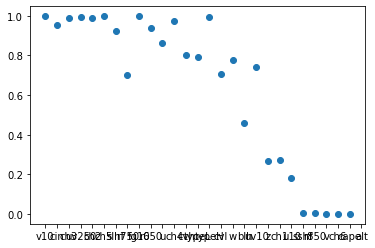

In [170]:
plt.scatter(np.array(varss)[res["indxVar"]], res["pval"])

/home/emiliano/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


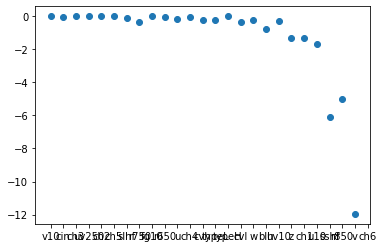

In [171]:
plt.scatter(np.array(varss)[res["indxVar"]], np.log(res["pval"]))

## Get AUC for model with novars and with only E vars

### Get figure 2 from paper

In [172]:
df = pd.DataFrame({"var":np.array(varss)[res["indxVar"]], "pval":res["pval"], "auc_noE":res["auc_noE"], "auc_E":res["auc_E"]})
df.head()

,var,pval,auc_noE,auc_E
0,v10,0.997088,0.902236,0.898294
1,cin,0.952975,0.901019,0.898847
2,ch3,0.987611,0.899939,0.896900
3,uv250,0.991573,0.900524,0.897368
4,ch2,0.988864,0.900655,0.897666


In [173]:
ML_ready_root

'../data/'

### Figure 2a

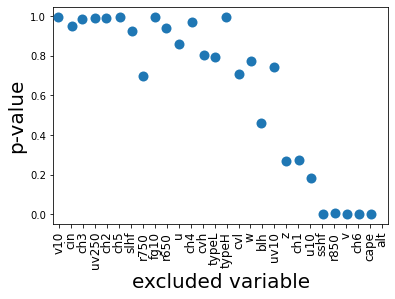

In [174]:
df2 = df.copy()
df2["dummy"] = 1
g = sns.stripplot(data=df2, x="var", y="pval", hue="dummy",size=10)
plt.xticks(rotation=90)
plt.xticks(size=12)
plt.xlabel("excluded variable",size=20)
plt.ylabel("p-value",size=20)
#g.set(xlabel='excluded variable', ylabel='p-value')
#plt.legend(bbox_to_anchor=(1.25, 1),borderaxespad=0)
plt.legend([],[], frameon=False)
#plt.savefig(ML_ready_root+"results/greedyICP_pval.png", format='png', dpi=300)

In [175]:
df  =pd.melt(df, id_vars="var")
df.head()

,var,variable,value
0,v10,pval,0.997088
1,cin,pval,0.952975
2,ch3,pval,0.987611
3,uv250,pval,0.991573
4,ch2,pval,0.988864


### Figure 2b

[None, None]

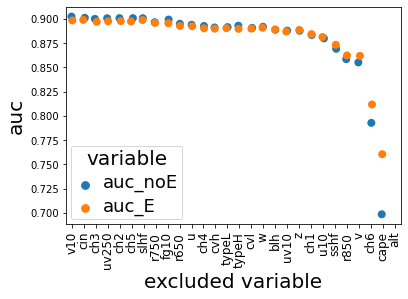

In [176]:
g = sns.stripplot(data=df.loc[df.variable!="pval"], x="var", y="value", hue="variable", size=8)
plt.xticks(rotation=90)
plt.xticks(size=12)
plt.xlabel("excluded variable",size=20)
plt.ylabel("auc",size=20)
plt.setp(g.get_legend().get_texts(), fontsize='18') # for legend text
plt.setp(g.get_legend().get_title(), fontsize='20') # for legend title
#g.set(xlabel='excluded variable', ylabel='p-value')
#plt.legend(bbox_to_anchor=(1.25, 1),borderaxespad=0)
#plt.savefig(ML_ready_root+"results/greedyICP_auc.png", format='png', dpi=300)

In [177]:
len(res["indxVar"])

28

In [178]:
np.sum([comb(12,i) for i in range(6,12)])
# 793

2509.0

In [179]:
elapsed_time*2500/60/60 #5 hours

3.4438239203559024e-05

In [180]:
np.array(varss)[res["indxVar"]]

array(['v10', 'cin', 'ch3', 'uv250', 'ch2', 'ch5', 'slhf', 'r750', 'fg10',
       'r650', 'u', 'ch4', 'cvh', 'typeL', 'typeH', 'cvl', 'w', 'blh',
       'uv10', 'z', 'ch1', 'u10', 'sshf', 'r850', 'v', 'ch6', 'cape',
       'alt'], dtype='<U5')

In [181]:
np.array(varss)[res["indxVar"]]

array(['v10', 'cin', 'ch3', 'uv250', 'ch2', 'ch5', 'slhf', 'r750', 'fg10',
       'r650', 'u', 'ch4', 'cvh', 'typeL', 'typeH', 'cvl', 'w', 'blh',
       'uv10', 'z', 'ch1', 'u10', 'sshf', 'r850', 'v', 'ch6', 'cape',
       'alt'], dtype='<U5')

In [182]:
varss

['ch1',
 'ch2',
 'ch3',
 'ch4',
 'ch5',
 'ch6',
 'u10',
 'v10',
 'fg10',
 'blh',
 'cape',
 'cin',
 'z',
 'slhf',
 'sshf',
 'w',
 'u',
 'v',
 'cvh',
 'cvl',
 'tvh',
 'tvl',
 'r650',
 'r750',
 'r850',
 'uv10',
 'uv250',
 'alt',
 'typeH',
 'typeL']

In [183]:
np.array(varss)[res["indxVar"][::-1][0:11]]

array(['alt', 'cape', 'ch6', 'v', 'r850', 'sshf', 'u10', 'ch1', 'z',
       'uv10', 'blh'], dtype='<U5')

In [184]:
indxIncl = res["indxVar"][::-1][0:11]
print(len(indxIncl))
np.array(varss)[indxIncl]

11


array(['alt', 'cape', 'ch6', 'v', 'r850', 'sshf', 'u10', 'ch1', 'z',
       'uv10', 'blh'], dtype='<U5')

In [185]:
[i for i in range(8,12)]

[8, 9, 10, 11]

In [186]:
np.array(varss)[res["indxVar"]]

array(['v10', 'cin', 'ch3', 'uv250', 'ch2', 'ch5', 'slhf', 'r750', 'fg10',
       'r650', 'u', 'ch4', 'cvh', 'typeL', 'typeH', 'cvl', 'w', 'blh',
       'uv10', 'z', 'ch1', 'u10', 'sshf', 'r850', 'v', 'ch6', 'cape',
       'alt'], dtype='<U5')

## Run exhaustive ICP on all combinations of size 8 or larger from 12 variables selected using greedy ICP

In [187]:
#varsSelec = ['v10','v','ch1','alt','sshf','u10','ch6','z','r650','cape','ch5','r850']#
varsSelec = ['alt', 'cape', 'ch6', 'v', 'r850', 'sshf', 'u10', 'ch1', 'z','uv10', 'blh']

In [188]:
i = 0
indxIncl = np.sort([findIndxAux(varss, varsSelec, i) for i in range(len(varsSelec))]).tolist()

In [189]:
i = 8
combos = dp.flatten([list(combinations(np.array(varss)[indxIncl], i)) for i in range(8,12)])
#combos = dp.flatten([list(combinations(np.array(varss)[indxIncl], i)) for i in range(4,12)])

In [190]:
len(combos)

232

In [191]:
combos = [list(c) for c in combos]

In [192]:
start_time = time.time()
#res_ex = exhaustiveICP(cube, labels, envVars[:,0:3], event_df, cluster_var, varss, combos, posts, numTrees=100)
elapsed_time = time.time() - start_time
print("elapsed time: ", elapsed_time) # 30 secs for 5 folds, 10 combs each


elapsed time:  7.081031799316406e-05


In [193]:
results_root = "/home/emiliano/Documents/FDL/clean_code/results/"
version = "v_1Tail_0"
file = "exhaustiveICP_8_11"
fileRes = results_root+file+"_"+version+"_pvals.pkl" 

In [194]:
#results_root = "/home/jupyter/ML_ready/results/"
#version = "v_1Tail_0"
#file = "exhaustiveICP_8_11"
#fileRes = results_root+file+"_"+version+"_pvals.pkl" 

In [195]:
#with open(fileRes, 'wb') as output:  # Overwrites any existing file.
#        pickle.dump(res_ex, output, pickle.HIGHEST_PROTOCOL)


In [196]:
res_ex = pickle5.load( open( fileRes, "rb" ) )

In [197]:
len(res_ex)

232

In [198]:
sig = 0.05
indxCombos, = np.where([r["pval_1tail"]>sig for r in res_ex])

In [199]:
combosPass = [combos[i] for i in indxCombos]
len(combosPass)

60

In [200]:
combosPass

[['ch1', 'ch6', 'u10', 'blh', 'cape', 'z', 'sshf', 'r850'],
 ['ch1', 'ch6', 'u10', 'blh', 'cape', 'z', 'sshf', 'alt'],
 ['ch1', 'ch6', 'u10', 'blh', 'cape', 'z', 'v', 'r850'],
 ['ch1', 'ch6', 'u10', 'blh', 'cape', 'z', 'r850', 'uv10'],
 ['ch1', 'ch6', 'u10', 'blh', 'cape', 'sshf', 'v', 'uv10'],
 ['ch1', 'ch6', 'u10', 'blh', 'cape', 'sshf', 'r850', 'alt'],
 ['ch1', 'ch6', 'u10', 'blh', 'cape', 'v', 'r850', 'uv10'],
 ['ch1', 'ch6', 'u10', 'blh', 'cape', 'v', 'uv10', 'alt'],
 ['ch1', 'ch6', 'u10', 'blh', 'cape', 'r850', 'uv10', 'alt'],
 ['ch1', 'ch6', 'u10', 'blh', 'z', 'sshf', 'v', 'r850'],
 ['ch1', 'ch6', 'u10', 'blh', 'z', 'v', 'r850', 'alt'],
 ['ch1', 'ch6', 'u10', 'blh', 'sshf', 'v', 'uv10', 'alt'],
 ['ch1', 'ch6', 'u10', 'cape', 'z', 'sshf', 'v', 'r850'],
 ['ch1', 'ch6', 'u10', 'cape', 'sshf', 'v', 'r850', 'uv10'],
 ['ch1', 'ch6', 'u10', 'z', 'sshf', 'r850', 'uv10', 'alt'],
 ['ch1', 'ch6', 'u10', 'z', 'v', 'r850', 'uv10', 'alt'],
 ['ch1', 'ch6', 'blh', 'cape', 'z', 'sshf', 'v', 'r85

In [201]:
len(combosPass)

60

In [202]:
len(combos)

232

In [203]:
np.array(varss)[indxIncl]

array(['ch1', 'ch6', 'u10', 'blh', 'cape', 'z', 'sshf', 'v', 'r850',
       'uv10', 'alt'], dtype='<U5')

In [204]:
ids, cnts = np.unique(dp.flatten(combosPass), return_counts=True)
df_freq = pd.DataFrame({"var":ids, "freq":cnts})
df_freq

,var,freq
0,alt,44
1,blh,51
2,cape,43
3,ch1,52
4,ch6,52
5,r850,51
6,sshf,41
7,u10,48
8,uv10,48
9,v,44


In [205]:
df_freq.freq

0     44
1     51
2     43
3     52
4     52
5     51
6     41
7     48
8     48
9     44
10    42
Name: freq, dtype: int64

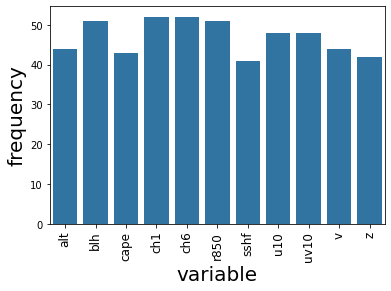

In [206]:
df_freq2 = df_freq.copy()
df_freq2["dummy"] = 1


sns.barplot(data=df_freq2, x="var", y="freq", hue="dummy")
plt.xticks(rotation=90)
plt.xticks(size=12)
plt.xlabel("variable",size=20)
plt.ylabel("frequency",size=20)
plt.legend([],[], frameon=False)


#plt.savefig(ML_ready_root+"results/accepted_sets_freq.png", format='png', dpi=300)

In [207]:
cmb = combosPass[0]
for i in range(1,len(combosPass)):
    cmb = set(cmb).intersection(combosPass[i])
list(cmb)

[]

In [208]:
results_root = "/home/emiliano/Documents/FDL/clean_code/results/"
version = "v_1Tail_0"
file = "exhaustiveICP_8_11"
fileRes = results_root+file+"_"+version+"_accepted_sets.json" 
fileRes

'/home/emiliano/Documents/FDL/clean_code/results/exhaustiveICP_8_11_v_1Tail_0_accepted_sets.json'

In [209]:
import json
#with open(fileRes, 'w') as f:
#    json.dump(combosPass, f)

## Appendix A.2 analysis: cluster variables and apply exhaustive ICP on clusters

In [210]:
maxSmpl = 100
smpl = np.random.choice(cube.shape[0], size=maxSmpl, replace=False)[:,None]

In [211]:
np.array(varss)[indxIncl]

array(['ch1', 'ch6', 'u10', 'blh', 'cape', 'z', 'sshf', 'v', 'r850',
       'uv10', 'alt'], dtype='<U5')

In [212]:
posts

array([  0,  11,  22,  33,  44,  55,  66,  77,  88,  99, 110, 121, 132,
       143, 154, 165, 176, 187, 198, 209, 220, 231, 242, 253, 264, 275,
       286, 297, 308, 312, 318])

In [213]:
indxs = [np.arange(posts[indxIncl[i]],posts[indxIncl[i]+1]) for i in range(len(indxIncl))]
indxs

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 array([66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]),
 array([ 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]),
 array([110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]),
 array([132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142]),
 array([154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164]),
 array([187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197]),
 array([264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274]),
 array([275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285]),
 array([297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307])]

In [214]:
type(hsicRBF_jax(cube[smpl,indxs[1]],cube[smpl,indxs[0]][:,None]))

/home/emiliano/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


jax.interpreters.xla.DeviceArray

In [215]:
type(sqeuclidean_distance(cube[0,:], cube[1,:]))

jax.interpreters.xla.DeviceArray

In [216]:
type(cube[0,:])

numpy.ndarray

In [217]:
hsicsVars = np.array([[ float(hsicRBF_jax(cube[smpl,indxs[k]],cube[smpl,indxs[j]][:,None]))  for k in range(len(indxs))] for j in range(len(indxs))])

In [218]:
for i in range(hsicsVars.shape[0]):
    hsicsVars[i,i] = np.nan

### Get figure 4 from paper

[[<matplotlib.axis.YTick at 0x7ff177f74990>,
 [Text(0, 0, 'ch1'),
  Text(0, 1, 'ch6'),
  Text(0, 2, 'u10'),
  Text(0, 3, 'blh'),
  Text(0, 4, 'cape'),
  Text(0, 5, 'z'),
  Text(0, 6, 'sshf'),
  Text(0, 7, 'v'),
  Text(0, 8, 'r850'),
  Text(0, 9, 'uv10'),
  Text(0, 10, 'alt')]]

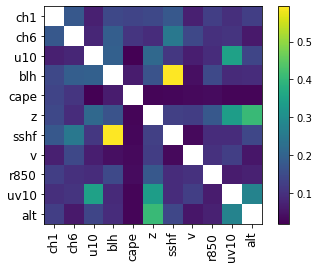

In [219]:
fig, ax = plt.subplots()
im= ax.imshow(hsicsVars)
fig.colorbar(im)
plt.xticks(rotation=90)
plt.xticks(size=12)
plt.yticks(size=12)
ax.xaxis.set(ticks=np.arange(0, len(indxIncl)), ticklabels=np.array(varss)[indxIncl])
ax.yaxis.set(ticks=np.arange(0, len(indxIncl)), ticklabels=np.array(varss)[indxIncl])
#plt.savefig(ML_ready_root+"results/hsic_12.png", format='png', dpi=300)

/home/emiliano/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

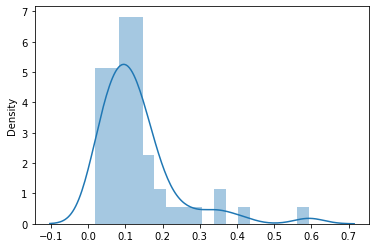

In [220]:
sns.distplot(hsicsVars)

### Get clusters

In [221]:
def depVars(x):
    indx, = np.where(x>0.25)
    return indx

depGrps = [[i]+depVars(hsicsVars[i,:]).tolist() for i in range(hsicsVars.shape[0])]

In [222]:
depGrps

[[0],
 [1],
 [2, 9],
 [3, 6],
 [4],
 [5, 9, 10],
 [6, 3],
 [7],
 [8],
 [9, 2, 5, 10],
 [10, 5, 9]]

In [223]:
set(depGrps[2]).issubset(depGrps[7])

False

In [224]:
i = 0
j = list(set(np.arange(hsicsVars.shape[0]).tolist()).difference([i]))[0]
indxKeep, = np.where([np.all(np.logical_not([set(depGrps[i]).issubset(depGrps[j]) for j in list(set(np.arange(hsicsVars.shape[0]).tolist()).difference([i]))])) for i in range(hsicsVars.shape[0])])
indxKeep

array([0, 1, 4, 7, 8, 9])

In [225]:
[depGrps[i] for i in indxKeep]

[[0], [1], [4], [7], [8], [9, 2, 5, 10]]

In [226]:
dp.flatten([depGrps[i] for i in indxKeep])

[0, 1, 4, 7, 8, 9, 2, 5, 10]

In [227]:
#depGrps = [depGrps[i] for i in indxKeep]
len(depGrps)

11

In [228]:
[np.array(varss)[indxIncl][d] for d in depGrps]

[array(['ch1'], dtype='<U5'),
 array(['ch6'], dtype='<U5'),
 array(['u10', 'uv10'], dtype='<U5'),
 array(['blh', 'sshf'], dtype='<U5'),
 array(['cape'], dtype='<U5'),
 array(['z', 'uv10', 'alt'], dtype='<U5'),
 array(['sshf', 'blh'], dtype='<U5'),
 array(['v'], dtype='<U5'),
 array(['r850'], dtype='<U5'),
 array(['uv10', 'u10', 'z', 'alt'], dtype='<U5'),
 array(['alt', 'z', 'uv10'], dtype='<U5')]

In [229]:
indxIncl

[0, 5, 6, 9, 10, 12, 14, 17, 24, 25, 27]

In [230]:
combosDep = dp.flatten([list(combinations(depGrps, i)) for i in range(1,12)])

In [231]:
len(combosDep)

2047

In [232]:
combosDep = [np.array(varss)[indxIncl][np.sort(np.unique(np.concatenate(list(c))))].tolist() for c in combosDep]

In [233]:
combosDep = np.unique(['-'.join(c) for c in combosDep]).tolist()

In [234]:
combosDep = [c.split("-") for c in combosDep]

In [235]:
len(combosDep)

255

In [236]:
combosDep

[['blh', 'cape', 'sshf'],
 ['blh', 'cape', 'sshf', 'r850'],
 ['blh', 'cape', 'sshf', 'v'],
 ['blh', 'cape', 'sshf', 'v', 'r850'],
 ['blh', 'cape', 'z', 'sshf', 'r850', 'uv10', 'alt'],
 ['blh', 'cape', 'z', 'sshf', 'uv10', 'alt'],
 ['blh', 'cape', 'z', 'sshf', 'v', 'r850', 'uv10', 'alt'],
 ['blh', 'cape', 'z', 'sshf', 'v', 'uv10', 'alt'],
 ['blh', 'sshf'],
 ['blh', 'sshf', 'r850'],
 ['blh', 'sshf', 'v'],
 ['blh', 'sshf', 'v', 'r850'],
 ['blh', 'z', 'sshf', 'r850', 'uv10', 'alt'],
 ['blh', 'z', 'sshf', 'uv10', 'alt'],
 ['blh', 'z', 'sshf', 'v', 'r850', 'uv10', 'alt'],
 ['blh', 'z', 'sshf', 'v', 'uv10', 'alt'],
 ['cape'],
 ['cape', 'r850'],
 ['cape', 'v'],
 ['cape', 'v', 'r850'],
 ['cape', 'z', 'r850', 'uv10', 'alt'],
 ['cape', 'z', 'uv10', 'alt'],
 ['cape', 'z', 'v', 'r850', 'uv10', 'alt'],
 ['cape', 'z', 'v', 'uv10', 'alt'],
 ['ch1'],
 ['ch1', 'blh', 'cape', 'sshf'],
 ['ch1', 'blh', 'cape', 'sshf', 'r850'],
 ['ch1', 'blh', 'cape', 'sshf', 'v'],
 ['ch1', 'blh', 'cape', 'sshf', 'v', 'r850

In [237]:
cluster_var

'cluster_random'

### exhaustive ICP based on variables in clusters

In [238]:
start_time = time.time()
#res_ex2 = exhaustiveICP(cube, labels, envVars[:,0:3], event_df, cluster_var, varss, combosDep, posts, numTrees=100)
elapsed_time = time.time() - start_time
print("elapsed time: ", elapsed_time) # for 5 folds, 1 rep each



elapsed time:  7.843971252441406e-05


In [239]:
results_root = "/home/emiliano/Documents/FDL/clean_code/results/"
version = "v_1Tail_0"
file = "exhaustiveICP_8_11_grouped"
#file = "exhaustiveICP_1_12_intersecRF_grouped"
fileRes = results_root+file+"_"+version+"_pvals.pkl" 

In [240]:
#with open(fileRes, 'wb') as output:  # Overwrites any existing file.
#        pickle.dump(res_ex2, output, pickle.HIGHEST_PROTOCOL)


In [241]:
res_ex2 = pickle5.load( open( fileRes, "rb" ) )

In [242]:
len(res_ex2)

28

In [243]:
sig = 0.05
indxCombos2, = np.where([ (r["pval_1tail"]>sig) for r in res_ex2])

In [244]:
[res_ex2[i] for i in indxCombos2]

[{'stat': 1.4329013212823132,
  'pval_1tail': 0.07594301982010432,
  'pval_2tail': 0.15188603964020858,
  'auc_E': 0.8906400078993935,
  'auc_noE': 0.8886883372262929},
 {'stat': 1.4632911606073036,
  'pval_1tail': 0.07169386271603839,
  'pval_2tail': 0.14338772543207676,
  'auc_E': 0.8894064637959431,
  'auc_noE': 0.8873512028434928},
 {'stat': 0.027684147735029616,
  'pval_1tail': 0.48895703356669584,
  'pval_2tail': 0.9779140671333917,
  'auc_E': 0.8913090967684594,
  'auc_noE': 0.8912748150932789},
 {'stat': 1.270263883290378,
  'pval_1tail': 0.10199532432276803,
  'pval_2tail': 0.20399064864553612,
  'auc_E': 0.8872583442189821,
  'auc_noE': 0.8855411303939635},
 {'stat': -0.033449295045557575,
  'pval_1tail': 0.513341850063552,
  'pval_2tail': 0.9733162998728959,
  'auc_E': 0.8882657783170032,
  'auc_noE': 0.8883107916470228},
 {'stat': -1.171400033966353,
  'pval_1tail': 0.8792809906846688,
  'pval_2tail': 0.24143801863066233,
  'auc_E': 0.8881121069817375,
  'auc_noE': 0.889733

In [245]:
type(res_ex2)

list

In [246]:
indxCombos2

array([ 0,  3,  7,  9, 10, 11, 14, 15, 16, 18, 20, 21])

In [247]:
combosPass2 = [combosDep[i] for i in indxCombos2]
len(combosPass2)

12

In [248]:
combosPass2

[['blh', 'cape', 'sshf'],
 ['blh', 'cape', 'sshf', 'v', 'r850'],
 ['blh', 'cape', 'z', 'sshf', 'v', 'uv10', 'alt'],
 ['blh', 'sshf', 'r850'],
 ['blh', 'sshf', 'v'],
 ['blh', 'sshf', 'v', 'r850'],
 ['blh', 'z', 'sshf', 'v', 'r850', 'uv10', 'alt'],
 ['blh', 'z', 'sshf', 'v', 'uv10', 'alt'],
 ['cape'],
 ['cape', 'v'],
 ['cape', 'z', 'r850', 'uv10', 'alt'],
 ['cape', 'z', 'uv10', 'alt']]

In [249]:
cmb2 = combosPass2[0]
for i in range(1,len(combosPass2)):
    cmb2 = set(cmb2).intersection(combosPass2[i])
list(cmb2)

[]

In [250]:
findIndxAux(varss, ["sshf"], 0)

14

In [251]:
findIndxAux(varss, ["cape"], 0)

10

In [252]:
depGrps

[[0],
 [1],
 [2, 9],
 [3, 6],
 [4],
 [5, 9, 10],
 [6, 3],
 [7],
 [8],
 [9, 2, 5, 10],
 [10, 5, 9]]

In [253]:
k = 0
j = 0
combosPass2_grp = [list(np.where([set(depGrps[k]).issubset([findIndxAux(np.array(varss)[indxIncl],combosPass2[j],i) for i in range(len(combosPass2[j]))]) for k in range(len(depGrps))]))[0].tolist() for j in range(len(combosPass2))]

In [254]:
cmb2_grp = combosPass2_grp[0]
for i in range(1,len(combosPass2_grp)):
    cmb2_grp = set(cmb2_grp).intersection(combosPass2_grp[i])
list(cmb2_grp)

[]

In [255]:
[depGrps[c] for c in list(cmb2_grp)]

[]

In [256]:
[np.array(varss)[indxIncl][d] for d in list(cmb2_grp)]

[]

In [257]:
[np.array(varss)[indxIncl][d] for d in [depGrps[c] for c in list(cmb2_grp)]]

[]

In [258]:
np.array(varss)[res["indxVar"]]

array(['v10', 'cin', 'ch3', 'uv250', 'ch2', 'ch5', 'slhf', 'r750', 'fg10',
       'r650', 'u', 'ch4', 'cvh', 'typeL', 'typeH', 'cvl', 'w', 'blh',
       'uv10', 'z', 'ch1', 'u10', 'sshf', 'r850', 'v', 'ch6', 'cape',
       'alt'], dtype='<U5')

## Validation of greedyICP causal ordering using regional cross-validation (Figure 3 from paper)

In [259]:
# impurity RF order
ordVars_RF = ['cvl','typeL','cvh','typeH','w','cin','ch2','sshf','u','slhf','uv250','blh','uv10','r750','r850','v','fg10',
 'ch1', 'ch3','ch4','u10','z','v10','alt','r650','ch5','ch6','cape']

# greedy-ICP order
ordVars_ICP = ['v10', 'cin', 'ch3', 'uv250', 'ch2', 'ch5', 'slhf', 'r750', 'fg10',
       'r650', 'u', 'ch4', 'cvh', 'typeL', 'typeH', 'cvl', 'w', 'blh',
       'uv10', 'z', 'ch1', 'u10', 'sshf', 'r850', 'v', 'ch6', 'cape',
       'alt']

In [260]:
i = 1
unions = [list(set(ordVars_RF[::-1][0:i]).union(ordVars_ICP[::-1][0:i])) for i in range(1, len(ordVars_RF))]

In [261]:
[len(u) for u in unions]

[2,
 3,
 4,
 6,
 7,
 9,
 11,
 12,
 13,
 15,
 16,
 18,
 19,
 20,
 22,
 23,
 23,
 25,
 26,
 26,
 26,
 27,
 28,
 28,
 28,
 28,
 28]

In [262]:
np.sum([comb(12,i) for i in range(12)])

4095.0

In [263]:
len(unions[7])
unions[7]

['cape',
 'u10',
 'z',
 'alt',
 'v',
 'ch5',
 'ch6',
 'sshf',
 'r650',
 'r850',
 'ch1',
 'v10']

In [264]:
ordVars = ordVars_ICP

In [265]:
combosOrd = [ordVars[i:len(ordVars)] for i in range(len(ordVars))]

In [266]:
len(ordVars)
len(combosOrd[0])

28

In [267]:
cluster_var

'cluster_random'

In [268]:
combosOrd

[['v10',
  'cin',
  'ch3',
  'uv250',
  'ch2',
  'ch5',
  'slhf',
  'r750',
  'fg10',
  'r650',
  'u',
  'ch4',
  'cvh',
  'typeL',
  'typeH',
  'cvl',
  'w',
  'blh',
  'uv10',
  'z',
  'ch1',
  'u10',
  'sshf',
  'r850',
  'v',
  'ch6',
  'cape',
  'alt'],
 ['cin',
  'ch3',
  'uv250',
  'ch2',
  'ch5',
  'slhf',
  'r750',
  'fg10',
  'r650',
  'u',
  'ch4',
  'cvh',
  'typeL',
  'typeH',
  'cvl',
  'w',
  'blh',
  'uv10',
  'z',
  'ch1',
  'u10',
  'sshf',
  'r850',
  'v',
  'ch6',
  'cape',
  'alt'],
 ['ch3',
  'uv250',
  'ch2',
  'ch5',
  'slhf',
  'r750',
  'fg10',
  'r650',
  'u',
  'ch4',
  'cvh',
  'typeL',
  'typeH',
  'cvl',
  'w',
  'blh',
  'uv10',
  'z',
  'ch1',
  'u10',
  'sshf',
  'r850',
  'v',
  'ch6',
  'cape',
  'alt'],
 ['uv250',
  'ch2',
  'ch5',
  'slhf',
  'r750',
  'fg10',
  'r650',
  'u',
  'ch4',
  'cvh',
  'typeL',
  'typeH',
  'cvl',
  'w',
  'blh',
  'uv10',
  'z',
  'ch1',
  'u10',
  'sshf',
  'r850',
  'v',
  'ch6',
  'cape',
  'alt'],
 ['ch2',
  'ch5',


In [269]:
from rf import *

In [270]:
np.random.seed(1234556)
num_reps = 1
seed = 1234
res = [getFold(cluster, cluster_var, cube, labels, event_df, num_reps, seed, byinistate=False, importance=False, shuffle=True) for cluster in np.unique(event_df[cluster_var])]

*********************************
FOLD:  0
*********************************
*********************************
REP:  0
seed:  92975
*********************************
num pyrocb train:  750
num pyrocb test:  417
*********************************
FOLD:  1
*********************************
*********************************
REP:  0
seed:  92975
*********************************
num pyrocb train:  861
num pyrocb test:  306
*********************************
FOLD:  2
*********************************
*********************************
REP:  0
seed:  92975
*********************************
num pyrocb train:  991
num pyrocb test:  176
*********************************
FOLD:  3
*********************************
*********************************
REP:  0
seed:  92975
*********************************
num pyrocb train:  997
num pyrocb test:  170
*********************************
FOLD:  4
*********************************
*********************************
REP:  0
seed:  92975
************************

In [271]:
def maxAUC(x):
    indx = np.argmax(x.auc)
    #print(indx)
    return x.iloc[indx]

In [272]:
res_msrs = [list(rm)[0] for rm in res]
res_msrs = pd.concat(res_msrs)
resMax = res_msrs[["rep","fold","auc","fpr","fnr"]].groupby(["fold"]).apply(maxAUC)#.reset_index()#.rename(columns={0:"auc"})
res = {"mean":np.mean(resMax.auc), "std":np.std(resMax.auc)}
print(res)
# for event {'mean': 0.5444933526439506, 'std': 0.070835034298292}
# for spatial {'mean': 0.4433585660768273, 'std': 0.07028088333880186}

{'mean': 0.5399690984146767, 'std': 0.07186609105626893}


In [273]:
posts =np.arange(0,cube.shape[1]+1-10, 11)
posts = np.array(posts.tolist()+[posts[posts.shape[0]-1]+4,posts[posts.shape[0]-1]+10])
posts

array([  0,  11,  22,  33,  44,  55,  66,  77,  88,  99, 110, 121, 132,
       143, 154, 165, 176, 187, 198, 209, 220, 231, 242, 253, 264, 275,
       286, 297, 308, 312, 318])

In [274]:
cluster_var

'cluster_random'

In [275]:
num_reps = 1
seed = 1234

start_time = time.time()
#resSeqICP = [getSeqICP(c, varss,posts, "cluster_regional", cube, labels, event_df, num_reps, seed) for c in combosOrd]
elapsed_time = time.time() - start_time
print("elapsed time: ", elapsed_time) # for 5 folds, 1 rep each



elapsed time:  3.314018249511719e-05


In [276]:
results_root = "/home/emiliano/Documents/FDL/clean_code/results/"

file = "rf_pred_era5_19vs_29vs"


version = "vRegion_ICP_selected"
#version = "vRand_ICP_selected"

fileRes = results_root+file+"_"+version+"ICPseq.png"
#fileRes = results_root+file+"_"+version+"RFimpurity_seq.png"
fileRes

'/home/emiliano/Documents/FDL/clean_code/results/rf_pred_era5_19vs_29vs_vRegion_ICP_selectedICPseq.png'

In [277]:
#with open(fileRes, 'wb') as output:  # Overwrites any existing file.
#        pickle.dump(resSeqICP, output, pickle.HIGHEST_PROTOCOL)


In [278]:
resSeqICP[0]

NameError: name 'resSeqICP' is not defined

In [ ]:
resICP_mean = [r["mean"] for r in resSeqICP]
resICP_std = [r["std"] for r in resSeqICP]

In [ ]:
plt.scatter(ordVars, resICP_mean)

In [ ]:
plt.scatter(ordVars, resICP_mean)

In [ ]:
plt.scatter(ordVars, resICP_std)

In [ ]:
plt.scatter(ordVars, resICP_std)

In [ ]:
len(ordVars)

In [ ]:
file

In [ ]:

# greedy-ICP order
ordVars = ['v10', 'cin', 'ch3', 'uv250', 'ch2', 'ch5', 'slhf', 'r750', 'fg10',
       'r650', 'u', 'ch4', 'cvh', 'typeL', 'typeH', 'cvl', 'w', 'blh',
       'uv10', 'z', 'ch1', 'u10', 'sshf', 'r850', 'v', 'ch6', 'cape',
       'alt']

results_root = "/home/emiliano/Documents/FDL/clean_code/results/"
file = "rf_pred_era5_19vs_29vs"

version = "vRand_ICP_selected"
fileRes = results_root+file+"_"+version+"ICPseq.pkl"

resSeqICPrand = pickle5.load( open( fileRes, "rb" ) )
resICPrand_mean = [r["mean"] for r in resSeqICPrand]
resICPrand_std = [r["std"] for r in resSeqICPrand]
df_rand = pd.DataFrame({"var":ordVars,"mean_AUC":resICPrand_mean, "std_AUC":resICPrand_std})
df_rand["CV"] = "random"
df_rand["order"] = "ICP"
df_rand["idx_var"] = np.arange(df_rand.shape[0])

In [ ]:
results_root = "/home/emiliano/Documents/FDL/clean_code/results/"
file = "rf_pred_era5_19vs_29vs"
version = "vRegion_ICP_selected"

fileRes = results_root+file+"_"+version+"ICPseq.pkl"

resSeqICPreg = pickle5.load( open( fileRes, "rb" ) )
resICPreg_mean = [r["mean"] for r in resSeqICPreg]
resICPreg_std = [r["std"] for r in resSeqICPreg]
df_region = pd.DataFrame({"var":ordVars,"mean_AUC":resICPreg_mean, "std_AUC":resICPreg_std})
df_region["CV"] = "regional"
df_region["order"] = "ICP"
df_region["idx_var"] = np.arange(df_region.shape[0])

In [ ]:
df = pd.concat([df_rand, df_region])
df = pd.melt(df, id_vars=["var","CV","order","idx_var"])
df.head()

In [ ]:
df = pd.concat([df_rand, df_region])
df = pd.melt(df, id_vars=["var","CV","order","idx_var"])
df.head()

In [ ]:
file

In [ ]:
version1 = "ICP_selected"

In [ ]:
fileRes = results_root+file+"_"+version1+"valid_AUC_mean_std.png"
fileRes

In [ ]:
g = sns.FacetGrid(df, col="variable",hue="CV",margin_titles=True, sharey=False)
g.map(sns.stripplot, "var", "value",  size=7)
#g.set(xlabel='variable excluded', ylabel='auc')
g.set_titles(col_template="{col_name}",size=16)
#g.set_titles(row_template="{row_name}",size=16)

    #g.set(xticks=onp.unique(resAux["num"]))
    #g.set_xticklabels(par_vals)

g.set_xticklabels(rotation=90)
g.set_xticklabels(size=10)


g.set_axis_labels("Seq. of excluded vars.", "auc", size=16)

g.add_legend()
#plt.legend(title='Team', fontsize='10', title_fontsize='14')

plt.setp(g._legend.get_title(), fontsize=20)
plt.setp(g._legend.get_texts(), fontsize=15)

#plt.legend(bbox_to_anchor=(1.3, 1),borderaxespad=0)
#g.savefig(fileRes, format='png', dpi=300)
    
    